##### https://github.com/netsatsawat/tutorial_fft_seasonality_detection/blob/master/FFT%20Tutorial.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_sin_wave(freq, time):
    return np.sin(2 * np.pi * freq * time)

In [3]:
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)

In [4]:
def create_cosine_wave(freq, time):
    return np.cos(2 * np.pi * freq * time)

In [5]:
start_tm, end_tm = 0, 2
signal1 = 12  # frequency of the wave
smpl_freq = 32 * signal1  # sampling frequency with oversampling factor=32
smpl_intv = 1 / smpl_freq  # intervals time points are sampled
tm = np.arange(start_tm, end_tm, smpl_intv)
ampl1 = np.sin(2 * np.pi * signal1 * tm)  # generate sine wave

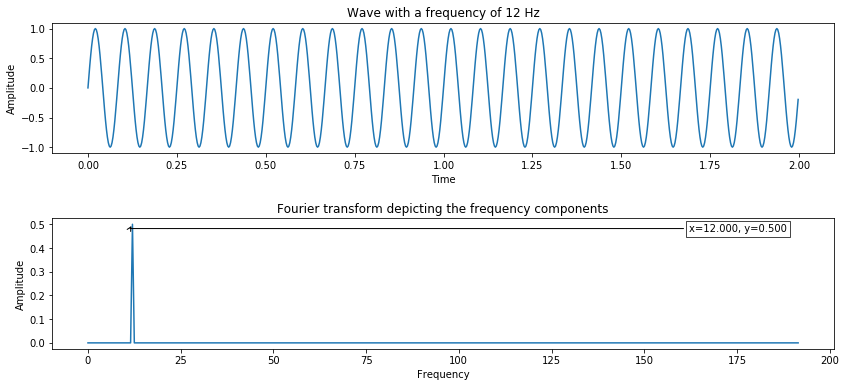

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))
plt.subplots_adjust(hspace=.5)
axes[0].set_title(f'Wave with a frequency of {signal1} Hz')
axes[0].plot(tm, ampl1)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
ft_ = np.fft.fft(ampl1) / len(ampl1)  # Normalize amplitude and apply the FFT
ft_ = ft_[range(int(len(ampl1)/2))]   # Exclude sampling frequency
tp_cnt = len(ampl1)
val_ = np.arange(int(tp_cnt / 2))
tm_period_ = tp_cnt / smpl_freq
freq_ = val_ / tm_period_
axes[1].set_title('Fourier transform depicting the frequency components')
axes[1].plot(freq_, abs(ft_))
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Amplitude')
annot_max(freq_, abs(ft_), ax=axes[1])
plt.show()

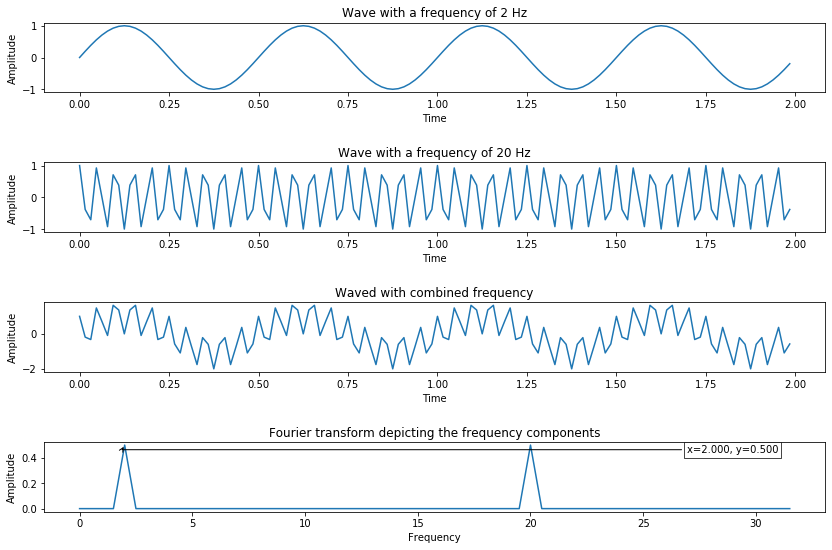

In [7]:
start_tm, end_tm = 0, 2
# Frequency of the signals
signal1Frequency = 2
signal2Frequency = 20
smpl_freq = 32*signal1Frequency
smpl_intv = 1 / smpl_freq  # intervals time points are sampled
tm = np.arange(start_tm, end_tm, smpl_intv)
# Create two sine waves
ampl1 = create_sin_wave(signal1Frequency, tm)
ampl2 = create_cosine_wave(signal2Frequency, tm)
combined_ampl = ampl1 + ampl2

fig, axes = plt.subplots(4, 1, figsize=(14, 9))
plt.subplots_adjust(hspace=1)
axes[0].set_title(f'Wave with a frequency of {signal1Frequency} Hz')
axes[0].plot(tm, ampl1)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[1].set_title(f'Wave with a frequency of {signal2Frequency} Hz')
axes[1].plot(tm, ampl2)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[2].set_title('Waved with combined frequency')
axes[2].plot(tm, combined_ampl)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Amplitude')

ft_ = np.fft.fft(combined_ampl) / len(combined_ampl)  # Normalize amplitude
ft_ = ft_[range(int(len(combined_ampl)/2))]  # Exclude sampling frequency
tp_cnt = len(combined_ampl)
val_ = np.arange(int(tp_cnt / 2))
tm_period_ = tp_cnt / smpl_freq
freq_ = val_ / tm_period_

# Frequency domain representation
axes[3].set_title('Fourier transform depicting the frequency components')
axes[3].plot(freq_, abs(ft_))
axes[3].set_xlabel('Frequency')
axes[3].set_ylabel('Amplitude')
annot_max(freq_, abs(ft_), ax=axes[3])
plt.show()

##### Real CO2 emission data

In [8]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors='coerce')
df = pd.read_csv("../Data/datasets_324_699_MER_T12_06.csv", 
                 parse_dates=['YYYYMM'], 
                 index_col='YYYYMM', 
                 date_parser=dateparse) 
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts.dropna(inplace=True)
ts.drop(['Unit', 'MSN', 'Column_Order'], axis=1, inplace=True)

FileNotFoundError: [Errno 2] File ../Data/datasets_324_699_MER_T12_06.csv does not exist: '../Data/datasets_324_699_MER_T12_06.csv'

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
_tmp_df = ts.reset_index()
for key, grp in _tmp_df.groupby('Description'):
    ax = grp.plot(ax=ax, kind='line', x='YYYYMM', y='Value', label=key, lw=2)
    
ax.legend(loc='upper left')
ax.set_xlabel('Time(Monthly)')
_ = plt.ylim(0, _tmp_df['Value'].max() * 1.25)
_ = plt.ylabel('Carbon Emissions (unit: Million Metric Tons)')
_ = plt.show()

In [ ]:
fig, axes = plt.subplots(3,3, figsize = (23, 14))
for (desc, group), ax in zip(_tmp_df.groupby('Description'), axes.flatten()):
    group.plot(x='YYYYMM', y='Value', title=desc, ax=ax)
    
plt.show()

In [ ]:
def get_indiv_emission(df, sel_desc: str, 
                       plot_mode: bool=True):
    _df = df.loc[df['Description'] == sel_desc]
    if plot_mode:
        _df.plot(x='YYYYMM', y='Value', figsize=(13, 6), legend=False, title=sel_desc)
        plt.show()
    
    _df = _df.set_index('YYYYMM')
    display(_df.head(3))
    return _df


sel_df = get_indiv_emission(_tmp_df, 'Natural Gas Electric Power Sector CO2 Emissions')

In [ ]:
from scipy.signal import blackman

def plot_ori_window(time_: np.ndarray, 
                    val_orig: pd.core.series.Series, 
                    val_window: pd.core.series.Series):
    plt.figure(figsize=(14, 10))
    plt.plot(time_, val_orig, label='raw')
    plt.plot(time_, val_window, label='windowed time')
    plt.legend()
    plt.show()
    return


def plot_ft_result(val_orig_psd: np.ndarray, 
                   val_widw_psd: np.ndarray,
                   ft_smpl_freq: np.ndarray,
                   pos: int=2, annot_mode: bool=True
                  ):
    """
    For PSD graph, the first few points are removed because it represents the baseline (or mean)
    """
    plt.figure(figsize=(14, 10))
    plt.plot(ft_smpl_freq[pos: ], val_orig_psd[pos: ], label='psd original value')
    plt.plot(ft_smpl_freq[pos: ], val_widw_psd[pos: ], label='psd windowed value')
    if annot_mode:
        annot_max(ft_smpl_freq[pos:], abs(val_widw_psd[pos: ]))
        
    plt.xlabel('frequency (1/Year)')
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    return


_val_orig = sel_df['Value']
_time = np.linspace(0, len(_val_orig) / 12, len(_val_orig), endpoint=False)
_val_widw = (_val_orig - np.median(_val_orig)) * blackman(len(_val_orig))

# rfft() method is used because the data is real valued
# rfftfreq() method is used to generate the frequency list (usage with rfft)
#  remark: the array f contains the frequency bin centers in cycles per unit of the sample spacing
#    with zero at the start. If the sample spacing is in years, then the frequency unit is cycles/year.
_val_orig_psd = abs(rfft(_val_orig))
_val_widw_psd = abs(rfft(_val_widw))
_val_freqs = rfftfreq(len(_val_orig), d=1./12.)

plot_ori_window(time_=_time, val_orig=_val_orig, val_window=_val_widw)
plot_ft_result(val_orig_psd=_val_orig_psd, val_widw_psd=_val_widw_psd, ft_smpl_freq=_val_freqs)

In [ ]:
tmp = pd.DataFrame({'freq':_val_freqs[2: ], 'y':_val_widw_psd[2: ]})
tmp['year'] = 1/tmp['freq']
tmp['months'] = tmp['year'] * 12
tmp.head(3)

In [ ]:
tmp.loc[tmp.y == max(tmp['y'])]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(_val_orig, model='multiplicative', freq=12)
fig = result.plot()
fig.set_size_inches(15, 8)
plt.show()